In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
from sklearn import *
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    # sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
from TuningCurveFuncs import makeTuningCurve, getTuningCurve_FullSpace, createFeatureBins, visualise_FeatureBins

os.chdir(wd)
subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
#set params for what file to load in per subject
binstep  = 15
binwidth = 22

times = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
ntimes = times.size
nitems = 2 #two items are presented in the array, we 'decode' both

nbins, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -75, feature_end = 90)

<font color='red'>

first, read in each participants trialwise tuning curve. This comes as a matrix of shape `[items (2) x trials x bins x times]`

two items were presented in the stimulus array on each trial. Each item is 'decoded' separately and independently on each trial, so we get a 'tuning curve' per item in the array.

the matrix contains mahalanobis distances, where smaller values reflect representations that are more similar to the test trial (leave one out procedure), and larger values reflect representations more *dissimilar* to the test trial. Because of this, we sign-flip the distances such that larger numbers (less negative/more positive) reflect more similar representations.

single-trial tuning curves are averaged across trials separately for each decoded item, so we build up a tuning curve for the left/right item separately.

In [3]:
alldata = np.zeros(shape = [subs.size, nitems, binmids.size, ntimes]) * np.nan #2 because 2 items decoded
subcount = -1
for i in subs:
    subcount +=1
    print(f'working on ppt {subcount+1}/{subs.size}')
    
    #read in single subject data
    data = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists_binstep{binstep}_binwidth{binwidth}.npy'))
    bdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_metadata.csv'))
    [nitems, ntrials, nbins, ntimes] = data.shape
    
    data = data * -1 #invert this, so more positive (larger) values = closer (mahalnobis distances are small when test is close to train)
    meandata = np.nanmean(data, axis=1)
    alldata[subcount] = meandata

alldata.shape

working on ppt 1/20
working on ppt 2/20
working on ppt 3/20
working on ppt 4/20
working on ppt 5/20
working on ppt 6/20
working on ppt 7/20
working on ppt 8/20
working on ppt 9/20
working on ppt 10/20
working on ppt 11/20
working on ppt 12/20
working on ppt 13/20
working on ppt 14/20
working on ppt 15/20
working on ppt 16/20
working on ppt 17/20
working on ppt 18/20
working on ppt 19/20
working on ppt 20/20


(20, 2, 12, 175)

<font color='red'>

next, for each participant and item, per time point, we demean the distances across bins to normalise each time point. This still preserves shape such that more positive values reflect representations that are more similar to the left-out test trial.

after that, we average across the two items in the display to get the average tuning curve for both items combined (i.e. representation quality of the entire array), before averaging across participants to get the grand-mean tuning curve for the stimulus display


In [4]:
#for each participant and decoded item, demean across bins at each time point
gmean_tp = alldata.copy()
for isub in range(nsubs):
    for iitem in range(nitems):
        for tp in range(ntimes):
            gmean_tp[isub, iitem, :, tp] = np.subtract(gmean_tp[isub, iitem, :, tp], gmean_tp[isub, iitem, :, tp].mean())

gmean_ave = gmean_tp.mean(axis=1) #average across items
gmean_ave = gmean_ave.mean(0) #average across participants now

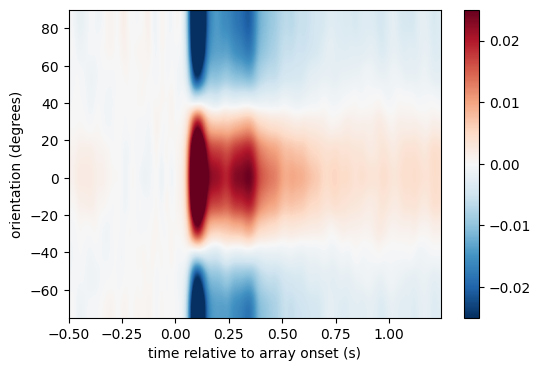

In [110]:
vlims = 0.025
fig = plt.figure(figsize = [6, 4])
ax = fig.add_subplot(111)
plot = ax.imshow(gmean_ave, aspect='auto', origin = 'lower', cmap = 'RdBu_r', interpolation='gaussian',
                 vmin = -vlims, vmax = vlims,
         extent = [times.min(), times.max(), binmids.min(), binmids.max()])
fig.colorbar(plot)
ax.set_ylabel(f'orientation (degrees)');
ax.set_xlabel(f'time relative to array onset (s)');

<font color='red'>

if we take windows of time in this tuning curve, we can plot the distances across orientation bins to observe how the shape of this curve changes over time

from this, fairly easy to see that pre-stimulus there is no real shape to the distribution of distances across orientations. Over time, there develops some orientation preference (leading to the cosine shape), which starts to decline in shape after 1s from stimulus onse.


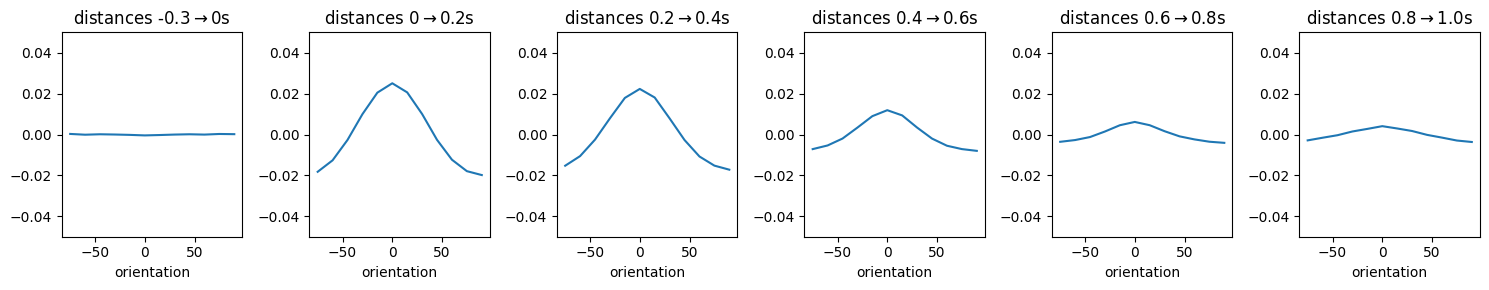

In [33]:
tstarts = [-0.3, 0,   0.2, 0.4, 0.6, 0.8]
tends   = [ 0,   0.2, 0.4, 0.6, 0.8, 1.0]
plotcount = np.arange(len(tstarts))+1
fig = plt.figure(figsize = [15, 3])
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times, x[1]), np.less_equal(times, x[2]))
    tmpdat = np.nanmean(gmean_ave[:,tinds], axis=1) #average across time
    ax.plot(binmids, tmpdat)
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    ax.set_ylim([-0.05, 0.05])
fig.tight_layout()